In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dfs = {
    'mimic_dBCQ': [],
    'mimic_dBCQf': [],
}
version_list = list(range(40))

for ver in version_list:
    meta = pd.read_csv(f'../a5cpu_BCQ/logs/mimic_dBCQ/version_{ver}/meta_tags.csv').set_index('key')
    df = pd.read_csv(f'../a5cpu_BCQ/logs/mimic_dBCQ/version_{ver}/metrics.csv')
    df['version'] = ver
    df['threshold'] = meta.loc['threshold'][0]
    df['seed'] = meta.loc['seed'][0]
    dfs['mimic_dBCQ'].append(df)
    
    meta = pd.read_csv(f'../a7cpu_BCQf/logs/mimic_dBCQf/version_{ver}/meta_tags.csv').set_index('key')
    df = pd.read_csv(f'../a7cpu_BCQf/logs/mimic_dBCQf/version_{ver}/metrics.csv')
    df['version'] = ver
    df['threshold'] = meta.loc['threshold'][0]
    df['seed'] = meta.loc['seed'][0]
    dfs['mimic_dBCQf'].append(df)

In [5]:
tau_list = [0.0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 0.9999]

In [6]:
colors = {
    '0.0': 'tab:red',
    '0.01': 'tab:orange',
    '0.05': 'tab:olive',
    '0.1': 'tab:green',
    '0.3': 'tab:cyan',
    '0.5': 'tab:blue',
    '0.75': 'tab:purple',
    '0.9999': 'tab:pink',
}

In [7]:
from operator import itemgetter, attrgetter
import numpy as np

# Reference: https://github.com/Ragheb2464/preto-front/blob/master/2d.py
def pareto2d(data):
    sorted_data = sorted(data, key=itemgetter(0, 1), reverse=True)
    pareto_idx = list()
    pareto_idx.append(0)
    cutoff = sorted_data[0][1]
    for i in range(1, len(sorted_data)):
        if sorted_data[i][1] > cutoff:
            pareto_idx.append(i)
            cutoff = sorted_data[i][1]
    return pareto_idx

## Pareto Frontier Validation Trade-offs

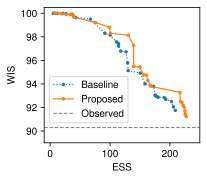

In [40]:
fig = plt.figure(figsize=(2.8,2.5))

dfs_1 = pd.concat(dfs['mimic_dBCQ']).sort_values(by=['val_wis', 'val_ess'], ascending=False)
pareto_idx = pareto2d(dfs_1[['val_wis', 'val_ess']].values)
plt.plot(dfs_1.iloc[pareto_idx]['val_ess'], dfs_1.iloc[pareto_idx]['val_wis'], ls=':', lw=1.2, marker='.', ms=5, c='tab:blue', label='Baseline', clip_on=False)

dfs_2 = pd.concat(dfs['mimic_dBCQf']).sort_values(by=['val_wis', 'val_ess'], ascending=False)
pareto_idx = pareto2d(dfs_2[['val_wis', 'val_ess']].values)
plt.plot(dfs_2.iloc[pareto_idx]['val_ess'], dfs_2.iloc[pareto_idx]['val_wis'], ls='-', lw=1.2, marker='.', ms=5, c='tab:orange', label='Proposed', clip_on=False)

plt.xlabel('ESS')
plt.ylabel('WIS')
plt.xlim(-10,250)
plt.ylim(89,100.5)
plt.axhline(90.2936, ls='--', lw=1, c='grey', label='Observed')
plt.legend(loc='best', bbox_to_anchor=(0.17, 0.125, 0.4, 0.4))
plt.savefig('./fig/mimic_validation_pareto_frontier.pdf', bbox_inches='tight')
plt.show()

## Test performance

In [41]:
state_dim = 64
num_actions = 25
horizon = 20

In [42]:
from a5cpu_BCQ.model import BCQ
from a5cpu_BCQ.data import remap_rewards
from a5cpu_BCQ.data import EpisodicBuffer as EpisodicBufferOO
from a7cpu_BCQf.model import BCQf
from a7cpu_BCQf.data import EpisodicBuffer as EpisodicBufferFF
from a7cpu_BCQf.model import all_subactions_vec

In [43]:
from evaluate import (
    EpisodicBufferO, offline_evaluation_O,
    EpisodicBufferF, offline_evaluation_F,
)

In [44]:
from torch.utils.data import DataLoader
from types import SimpleNamespace
from tqdm import tqdm

In [45]:
dfs_1 = pd.concat(dfs['mimic_dBCQ']).sort_values(by=['val_wis', 'val_ess'], ascending=False)
pareto_idx = pareto2d(dfs_1[['val_wis', 'val_ess']].values)
dfs_1_pareto = dfs_1.iloc[pareto_idx]

dfs_2 = pd.concat(dfs['mimic_dBCQf']).sort_values(by=['val_wis', 'val_ess'], ascending=False)
pareto_idx = pareto2d(dfs_2[['val_wis', 'val_ess']].values)
dfs_2_pareto = dfs_2.iloc[pareto_idx]

In [46]:
len(dfs_1_pareto), len(dfs_2_pareto)

(30, 30)

In [47]:
test_episodes_O = EpisodicBufferO(state_dim, num_actions, horizon)
test_episodes_O.load('../data/episodes+encoded_state+knn_pibs/test_data.pt')
test_episodes_O.reward = remap_rewards(test_episodes_O.reward, SimpleNamespace(**{'R_immed': 0.0, 'R_death': 0.0, 'R_disch': 100.0}))

tmp_test_episodes_loader_O = DataLoader(test_episodes_O, batch_size=len(test_episodes_O), shuffle=False)
test_batch_O = next(iter(tmp_test_episodes_loader_O))

Episodic Buffer loaded with 2894 episides.


In [48]:
results_1 = []
for _, row in tqdm(dfs_1_pareto.iterrows(), total=dfs_1_pareto.shape[0]):
    ver = row['version']
    iteration = int(row['iteration']-1)
    bcq_model = BCQ.load_from_checkpoint(
        checkpoint_path=f'../a5cpu_BCQ/logs/mimic_dBCQ/version_{ver}/checkpoints/step={iteration}.ckpt', map_location=None)
    bcq_model.eval()
    test_wis, test_ess = bcq_model.offline_evaluation(test_batch_O, weighted=True, eps=0.01)
    results_1.append((test_wis, test_ess))

100%|██████████| 30/30 [02:18<00:00,  4.63s/it]


In [49]:
results_2 = []
for _, row in tqdm(dfs_2_pareto.iterrows(), total=dfs_2_pareto.shape[0]):
    ver = row['version']
    iteration = int(row['iteration']-1)
    bcq_model = BCQf.load_from_checkpoint(
        checkpoint_path=f'../a7cpu_BCQf/logs/mimic_dBCQf/version_{ver}/checkpoints/step={iteration}.ckpt', map_location=None)
    bcq_model.eval()
    bcq_model.all_subactions_vec = all_subactions_vec
    test_wis, test_ess = offline_evaluation_O(bcq_model, test_batch_O, weighted=True, eps=0.01)
    results_2.append((test_wis, test_ess))

100%|██████████| 30/30 [02:13<00:00,  4.46s/it]


In [50]:
results_1 = np.array(results_1)
results_2 = np.array(results_2)

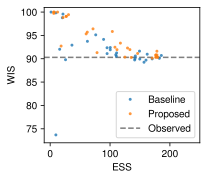

In [56]:
fig = plt.figure(figsize=(2.8,2.5))
plt.plot(results_1[:,1], results_1[:,0], ls='', marker='.', c='tab:blue', alpha=0.8, ms=6, mew=0, label='Baseline', zorder=10)
plt.plot(results_2[:,1], results_2[:,0], ls='', marker='.', c='tab:orange', alpha=0.8, ms=6, mew=0, label='Proposed', zorder=11)
plt.xlabel('ESS')
plt.ylabel('WIS')
plt.xlim(-10,250)
plt.ylim(72,101)
plt.axhline(90.2936, ls='--', c='grey', label='Observed')
plt.legend(loc='lower right')
plt.savefig('./fig/mimic_test_pareto_frontier.pdf', bbox_inches='tight')
plt.show()

## Model selection

In [50]:
# Sweep through all possible ESS thresholds
sweep_ESS_cutoffs = np.arange(250)
sweep_ESS_results = []
for ESS_cutoff in sweep_ESS_cutoffs:
    df_1_candidates = dfs_1_pareto.reset_index()
    df_1_candidates = df_1_candidates[df_1_candidates['val_ess'] >= ESS_cutoff].sort_values(by=['val_wis', 'val_ess'], ascending=False)
    df_2_candidates = dfs_2_pareto.reset_index()
    df_2_candidates = df_2_candidates[df_2_candidates['val_ess'] >= ESS_cutoff].sort_values(by=['val_wis', 'val_ess'], ascending=False)
    
    try:
        idx1 = df_1_candidates.index[0]
        res1 = results_1[idx1]
    except:
        res1 = [np.nan, np.nan]
    
    try:
        idx2 = df_2_candidates.index[0]
        res2 = results_2[idx2]
    except:
        res2 = [np.nan, np.nan]
    
    sweep_ESS_results.append(np.hstack([res1, res2]))

In [55]:
df_sweep_ESS_results = pd.DataFrame(sweep_ESS_results, columns=['Baseline WIS', 'Baseline ESS', 'Proposed WIS', 'Proposed ESS'])

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(4,6), sharex=True)
plt.sca(axes[0])
plt.plot(df_sweep_ESS_results['Baseline WIS'], c='tab:blue', label='Baseline')
plt.plot(df_sweep_ESS_results['Proposed WIS'], c='tab:orange', label='Proposed')
plt.ylabel('Test WIS')
plt.grid(axis='x')

plt.sca(axes[1])
plt.plot(df_sweep_ESS_results['Baseline ESS'], c='tab:blue', label='Baseline')
plt.plot(df_sweep_ESS_results['Proposed ESS'], c='tab:orange', label='Proposed')
plt.ylabel('Test ESS')
plt.grid(axis='x')

plt.xlim(-10, 260)
plt.xlabel('Validation ESS cutoff')
plt.legend()

plt.savefig('./fig/mimic_model_selection.pdf', bbox_inches='tight')
plt.show()

In [58]:
ESS_cutoff = 200

In [59]:
df_1_candidates = dfs_1_pareto.reset_index()
df_1_candidates = df_1_candidates[df_1_candidates['val_ess'] >= ESS_cutoff].sort_values(by=['val_wis', 'val_ess'], ascending=False)
df_2_candidates = dfs_2_pareto.reset_index()
df_2_candidates = df_2_candidates[df_2_candidates['val_ess'] >= ESS_cutoff].sort_values(by=['val_wis', 'val_ess'], ascending=False)

In [60]:
df_1_candidates

,index,iteration,val_qvalues,val_wis,val_ess,epoch,created_at,version,threshold,seed
27,97,9800.0,11.247806,92.497391,202.913132,5,2021-11-15 19:47:41.309691,17,0.5,1
28,74,7500.0,7.519732,92.051239,205.987076,4,2021-11-15 19:38:03.405003,20,0.75,3
29,83,8400.0,8.809665,91.755821,209.069580,5,2021-11-15 19:41:24.363820,1,0.75,1


In [61]:
df_2_candidates

,index,iteration,val_qvalues,val_wis,val_ess,epoch,created_at,version,threshold,seed
22,90,9100.0,10.518903,93.288460,216.866272,5,2021-11-15 19:51:43.311177,27,0.5,4
23,88,8900.0,7.750560,92.512802,217.469864,5,2021-11-15 19:49:34.022458,32,0.9999,4
24,71,7200.0,6.669207,92.418861,220.240982,4,2021-11-15 19:39:39.964624,9,0.75,0
25,75,7600.0,6.563459,92.191071,222.134018,4,2021-11-15 19:41:23.449181,32,0.9999,4
26,98,9900.0,10.118005,92.029709,223.747955,5,2021-11-15 19:56:23.100589,9,0.75,0
27,89,9000.0,8.968600,91.688118,224.934479,5,2021-11-15 19:50:54.136458,9,0.75,0
28,91,9200.0,9.153830,91.433876,225.553955,5,2021-11-15 19:52:18.658701,29,0.75,4
29,90,9100.0,9.348545,91.223122,227.158554,5,2021-11-15 19:48:52.930155,5,0.75,1


In [62]:
idx1 = df_1_candidates.index[0]
idx2 = df_2_candidates.index[0]

In [63]:
print('Test performance')
print('Baseline BCQ', idx1, results_1[idx1])
print('Factored BCQ', idx2, results_2[idx2])

Test performance
Baseline BCQ 27 [ 90.44146456 178.3243348 ]
Factored BCQ 22 [ 91.61631218 178.32186364]


In [64]:
df_1_candidates.loc[[idx1]].to_csv('best_BCQ_meta.csv', index=False)
df_2_candidates.loc[[idx2]].to_csv('best_BCQf_meta.csv', index=False)